# Проект 3.   
# EDA + Feature Engineering. Соревнование на Kaggle

Ноутбук на Kaggle https://www.kaggle.com/code/kseniyamasnikova/my-solution   
Ник на Kaggle Kseniya Masnikova

# Подготовка данных

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#'/kaggle/input/sf-booking/'
for dirname, _, filenames in os.walk('/sf-booking'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


zsh:1: /usr/local/bin/pip: bad interpreter: /System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: no such file or directory


In [2]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
#DATA_DIR = 'sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [7]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [8]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# Очистка данных

### Пропуски

In [5]:
# смотрим, в каких столбцах есть пропуски и какой процент этих пропусков
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

lat    0.633655
lng    0.633655
dtype: float64

In [6]:
# заполняем пропуски медианными значениями
data['lat'].fillna(data['lat'].median(), inplace=True)
data['lng'].fillna(data['lng'].median(), inplace=True)

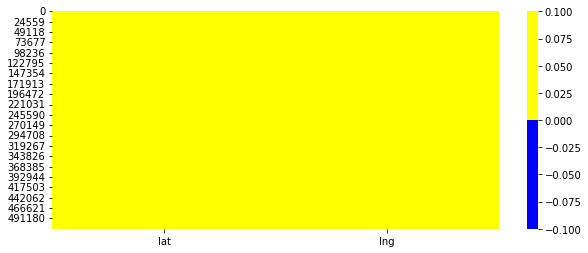

In [8]:
# ещё раз проверяем пропуски на тепловой карте
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    data[cols].isnull(),
    cmap=sns.color_palette(colors),
);

Пропусков больше нет. Так как в задании к проекту было указано, что удалять можно только столбцы, а не строки, проверку на выбросы и дубликаты пропустим.

# Обработка строковых признаков и создание новых

### Признак hotel_address

In [7]:
# из признака с адресом делаем 2 новых столбца - страну и город
def country(address):
    c = address.split()
    if c[-1] == 'Kingdom':
        kingdom = ' '.join(c[-2:])
        return kingdom
    return c[-1]

def city(address):
    c = address.split()
    if c[-2] == 'United':
        return c[-5]
    return c[-2]


data['country'] = data['hotel_address'].apply(country)
data['city'] = data['hotel_address'].apply(city)

In [13]:
print(data['country'].nunique())
print(data['city'].nunique())

6
6


Так как у признаков всего по 6 уникальных значений, можем использовать OneHot Encoding

In [8]:
encoder = ce.OneHotEncoder(cols=['country']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)

encoder = ce.OneHotEncoder(cols=['city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['city'])
data = pd.concat([data, type_bin], axis=1)

data

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,country_3,country_4,country_5,country_6,city_1,city_2,city_3,city_4,city_5,city_6
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,0,1,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,0,0,0,1,0,0,0,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,1,0,0,0,0,0,1,0,0,0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,0,0,0,0,1,0,0,0,0,0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,...,0,1,0,0,0,0,0,1,0,0
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,...,0,0,0,1,0,0,0,0,0,1
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,...,0,1,0,0,0,0,0,1,0,0
515736,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,...,0,1,0,0,0,0,0,1,0,0


### Признак review_date

In [9]:
# переведём дату в формат datetime и из даты отзыва создадим 3 новых признака (год, месяц и день)

data['review_date'] = pd.to_datetime(data['review_date'])
data['year'] = data['review_date'].dt.year
data['month'] = data['review_date'].dt.month
data['day'] = data['review_date'].dt.day


### Признак reviewer_nationality

In [10]:
data['reviewer_nationality'].nunique()

227

In [11]:
# используем бинарное кодирование
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)


In [12]:
# создадим новый признак - совпадает ли страна человека, оставившего отзыв, со страной, где находится отель
# предварительно удалилим лишние пробелы у строк признака reviewer_nationality
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())
mask = data['reviewer_nationality'] == data['country']
data['equal countries'] = (data['reviewer_nationality'] == data['country']).astype(np.int8)

### Признак days_since_review

In [13]:
# уберём в значениях признака days_since_review слово 'day', чтобы перевести признак в числовой формат

data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))

### Признаки negative_review и positive_review

In [14]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

# функция для обработки отзывов (распознование интонаций)
def review_analyz(review):
    neg = list()
    neu = list()
    pos = list()
    compound = list()
    for i in range(len(review)):
        score = sent_analyzer.polarity_scores(review.iloc[i])
        neg.append(score['neg'])
        neu.append(score['neu'])
        pos.append(score['pos'])
        compound.append(score['compound'])
    return neg, neu, pos, compound

# обработка позитивных отзывов
neg, neu, pos, compound = review_analyz(data['positive_review'])
data['positive_neg'] = neg
data['positive_neu'] = neu
data['positive_pos'] = pos
data['positive_compound'] = compound


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# обработка негативных отзывов
neg, neu, pos, compound = review_analyz(data['negative_review'])
data['negative_neg'] = neg
data['negative_neu'] = neu
data['negative_pos'] = pos
data['negative_compound'] = compound

In [15]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,equal countries,positive_neg,positive_neu,positive_pos,positive_compound
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,0,1,0,0.000,0.671,0.329,0.9615
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,0,1,0,0,0.379,0.000,0.621,0.3400
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,0,0,0,1,1,0,0.000,0.260,0.740,0.6908
3,Piazza Della Repubblica 17 Central Station 201...,241,2015-10-17,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,...,0,0,1,0,0,0,0.000,0.621,0.379,0.9153
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,2016-05-16,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,...,0,0,0,0,1,0,0.000,0.230,0.770,0.7717


### Признак tags

In [16]:
# разберём признак tags. Значение признака - список тегов. Разберём этот список по отдельным тегам

def re_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

data['tags_new'] = data['tags'].apply(re_func)
data_tags = data.explode(('tags_new'))


In [17]:
# отбираем 30 самых часто встречающихся тегов
tags = data_tags['tags_new'].value_counts().index
tags = tags[:30]
tags

Index(['Leisure trip', 'Submitted from a mobile device', 'Couple',
       'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights',
       'Business trip', 'Group', 'Family with young children',
       'Stayed 4 nights', 'Double Room', 'Standard Double Room',
       'Superior Double Room', 'Family with older children',
       'Deluxe Double Room', 'Double or Twin Room', 'Stayed 5 nights',
       'Standard Double or Twin Room', 'Classic Double Room',
       'Superior Double or Twin Room', '2 rooms', 'Stayed 6 nights',
       'Standard Twin Room', 'Single Room', 'Twin Room', 'Stayed 7 nights',
       'Executive Double Room', 'Classic Double or Twin Room',
       'Superior Twin Room'],
      dtype='object')

In [18]:
# создаём новые признаки-маячки = есть ли этот тег в списки тегов отзыва
for i in range(len(tags)):
    data[tags[i]] = data['tags_new'].apply(lambda x: 1 if tags[i] in x else 0)

# Удаление нечисловых значений

In [19]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [20]:
data.drop('review_date', axis = 1, inplace=True)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 73 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   lat                                         515738 non-null  float64
 8   lng                                         515738 non-null  float64
 9   sample                                      515738 non-null  int64  
 

# Отбор признаков

### Корреляция

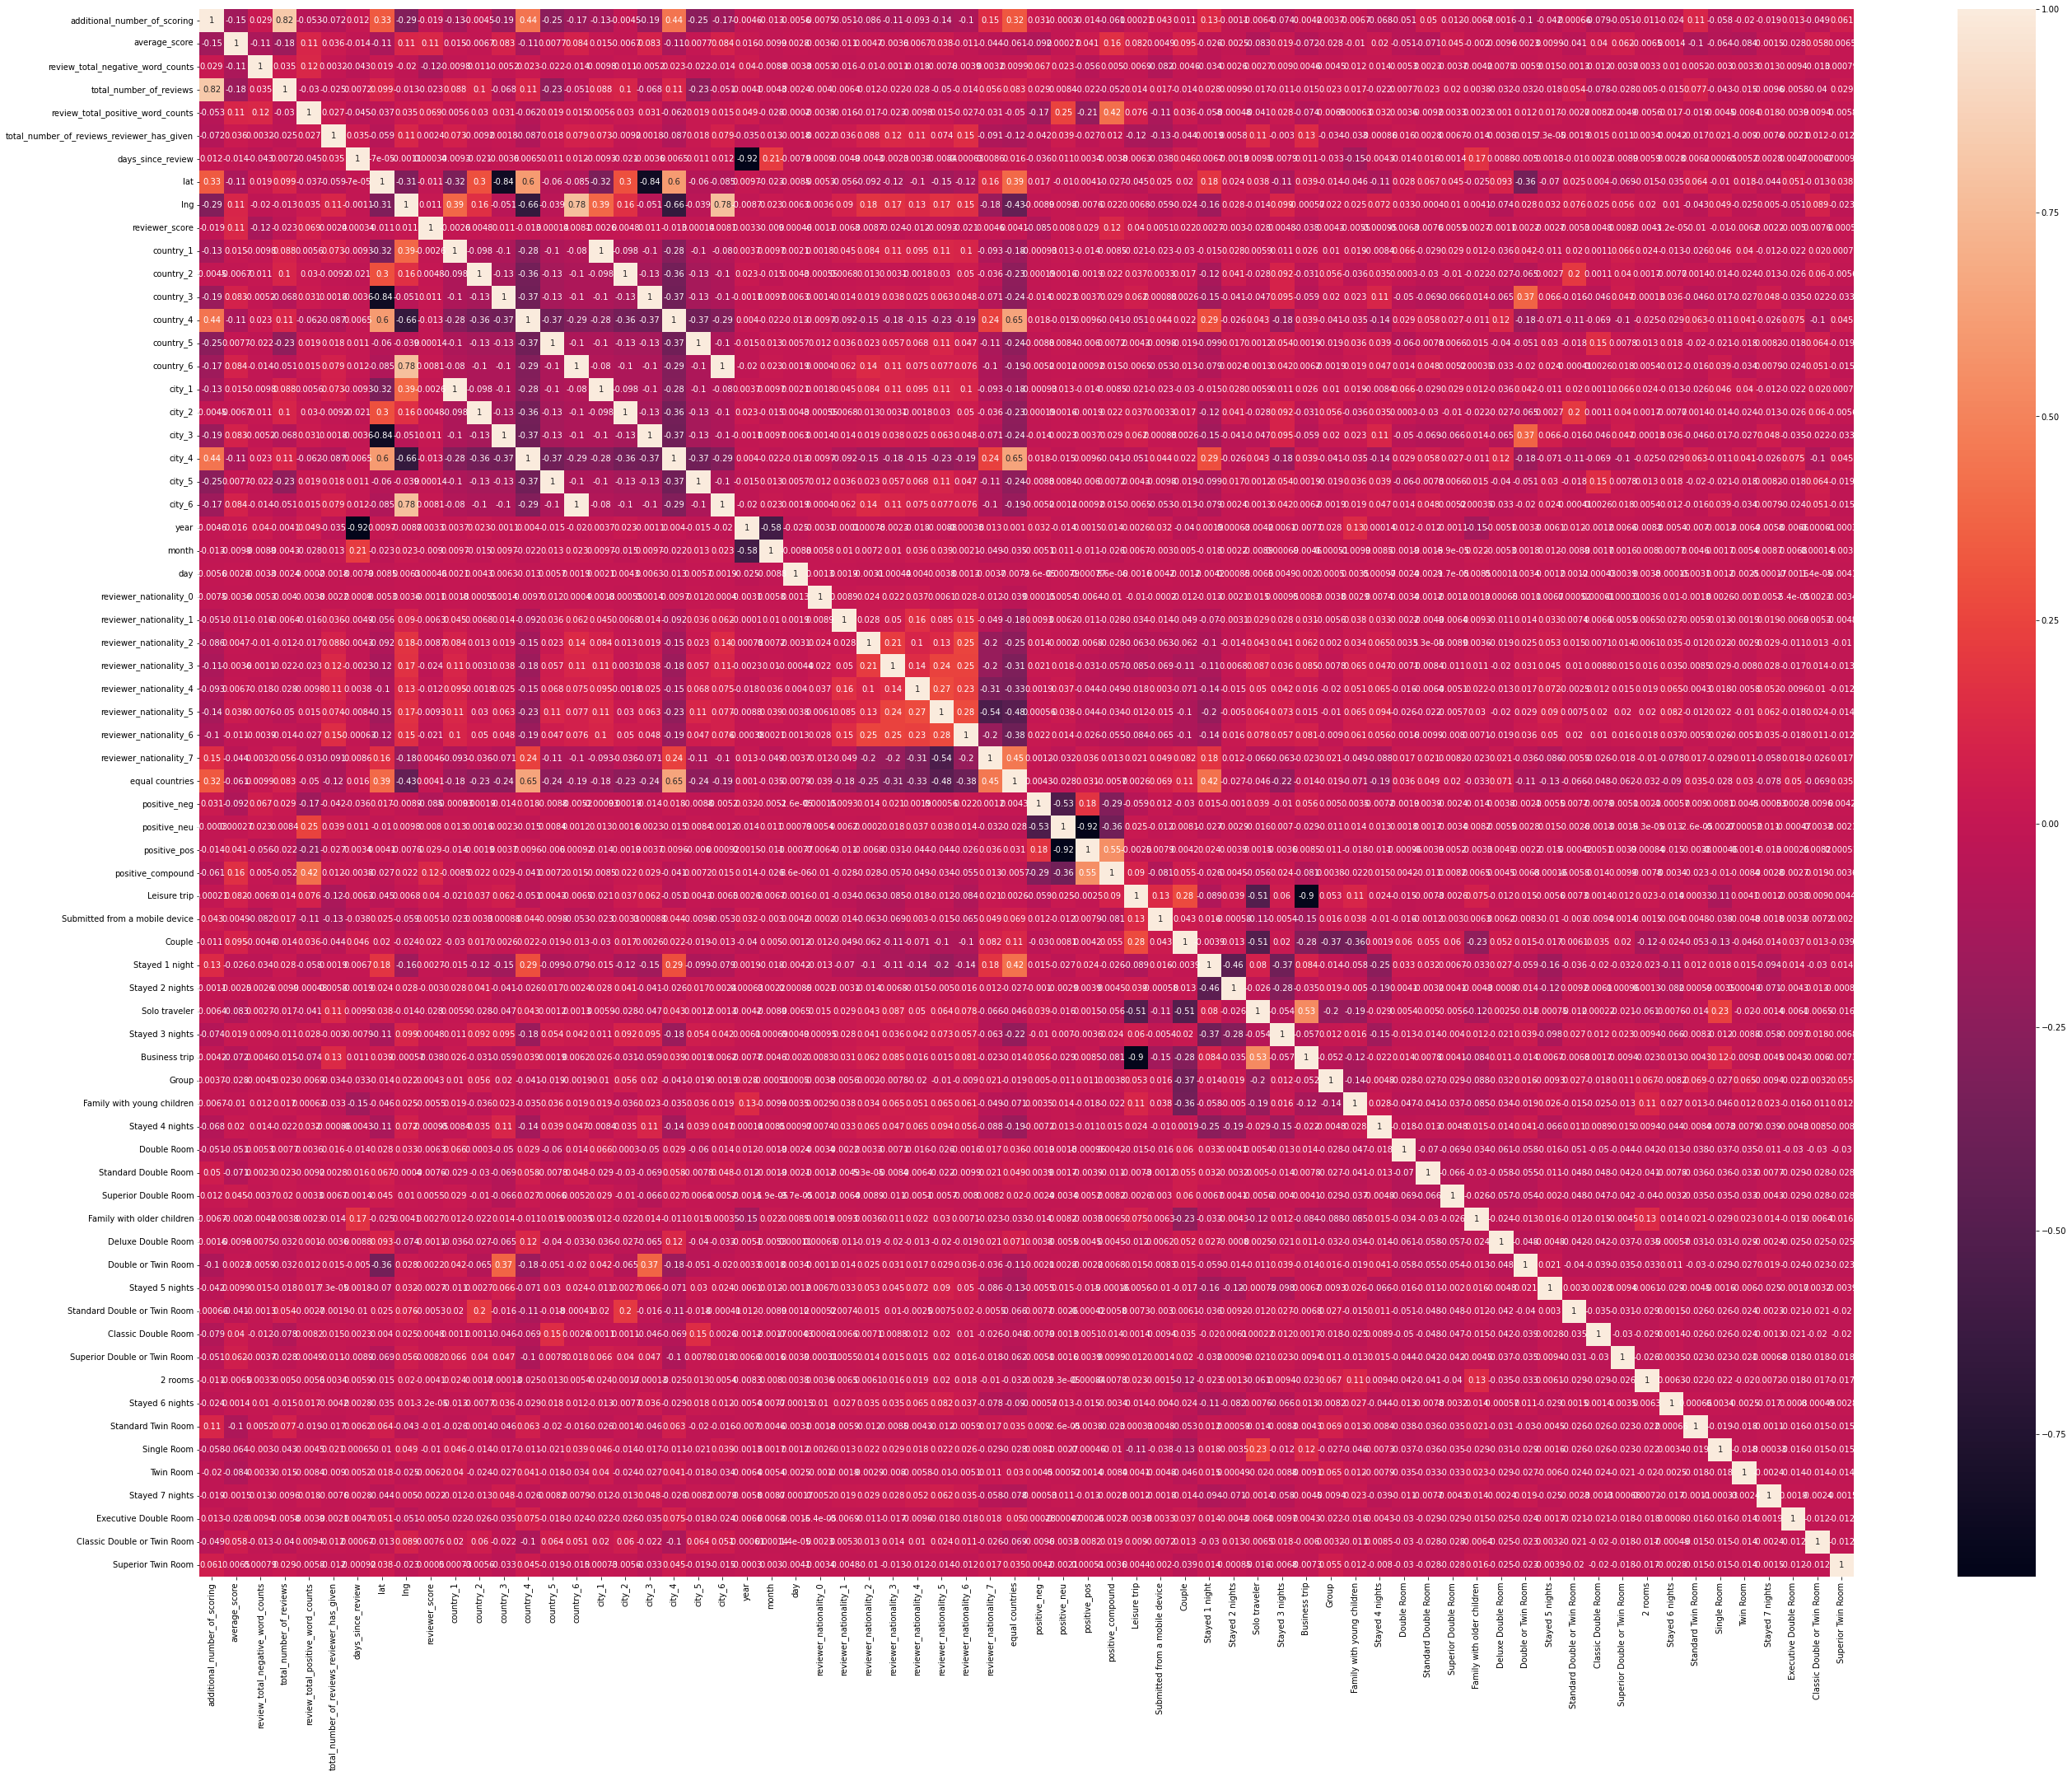

In [21]:
plt.rcParams['figure.figsize'] = (45, 35)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True);

### Влияние на целевую переменную

In [22]:
# бинарные признаки
bin_cols = list(tags)
bin_cols.extend(['equal countries', 'reviewer_nationality_0','reviewer_nationality_1','reviewer_nationality_2',
                    'reviewer_nationality_3','reviewer_nationality_4', 'reviewer_nationality_5','reviewer_nationality_6',
                    'reviewer_nationality_7'])
bin_cols.extend(['country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 
              'city_1', 'city_2', 'city_3', 'city_4', 'city_5', 'city_6'])

# категориальные признаки
cat_cols = ['year', 'month', 'day', 'average_score', 'lat']

# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'additional_number_of_scoring',
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lng']

In [23]:
cat_cols.extend(bin_cols)

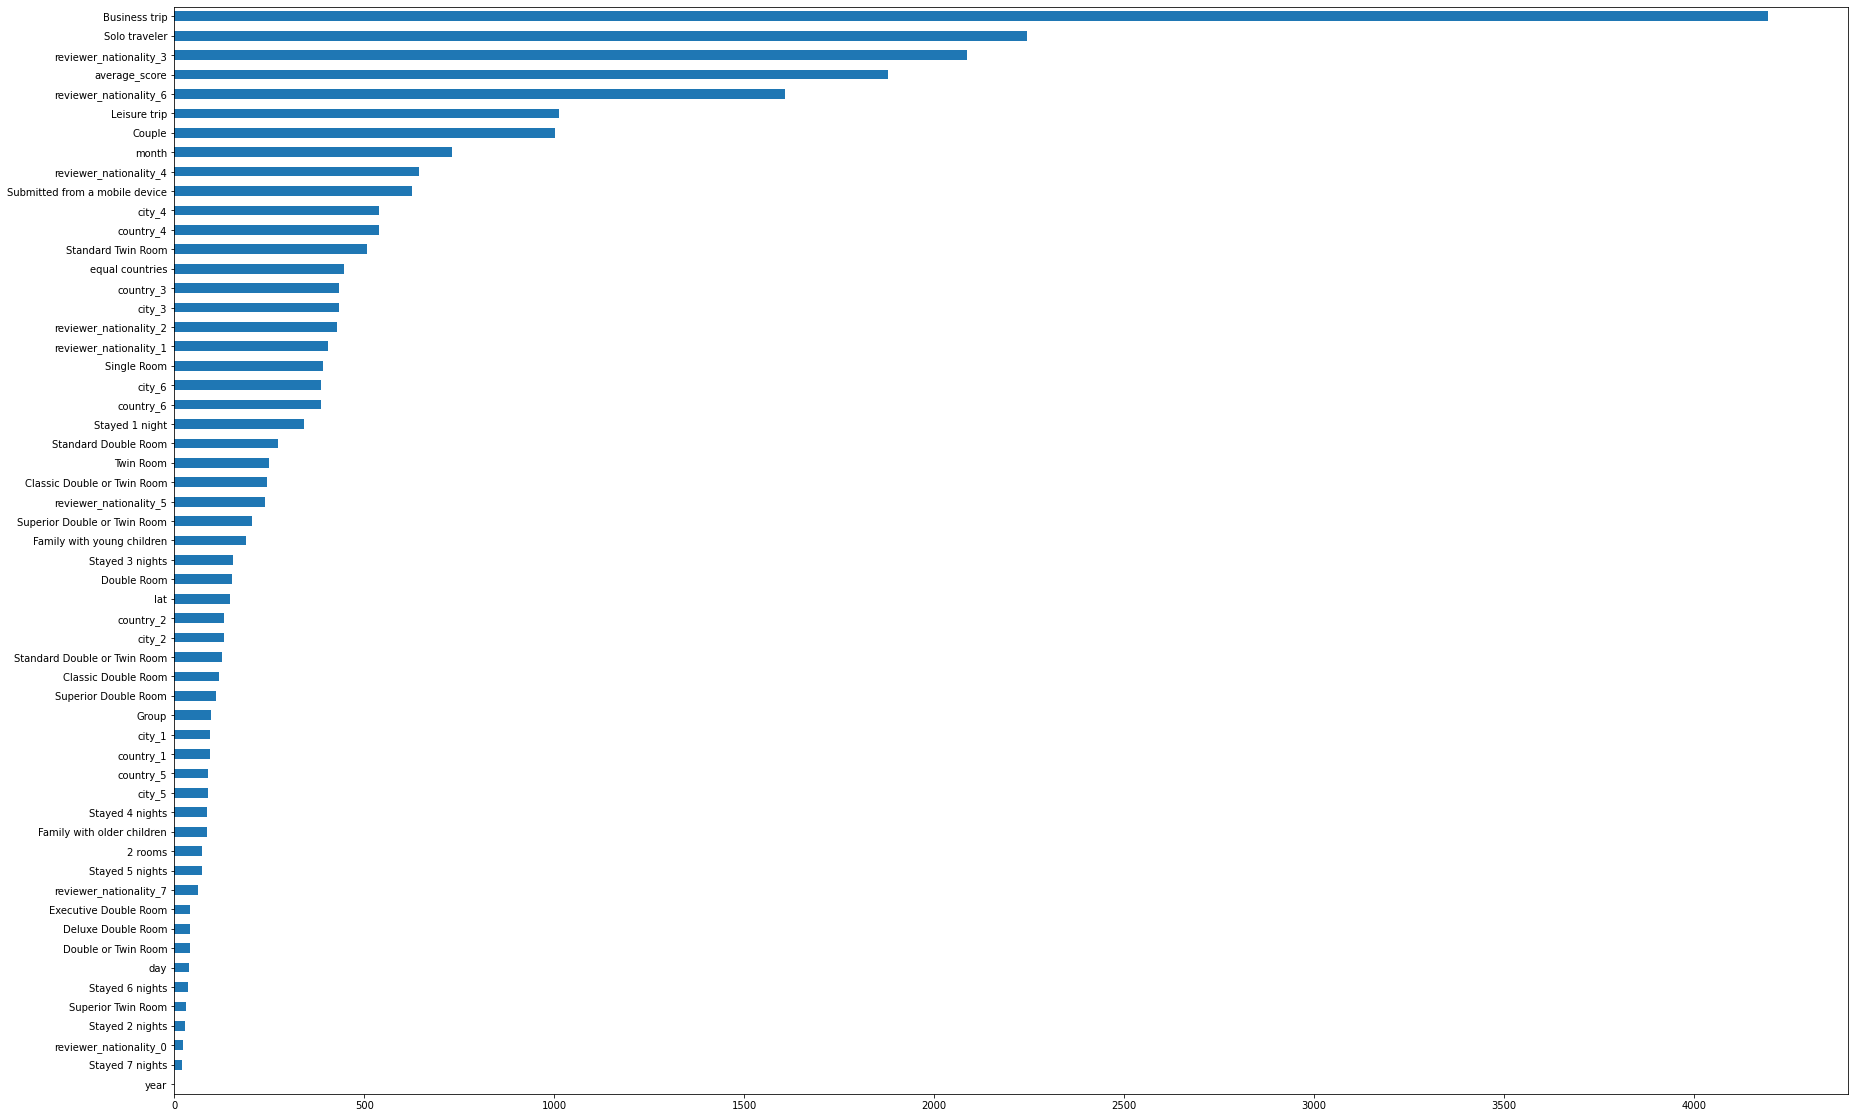

In [24]:
from sklearn.feature_selection import chi2 # хи-квадрат
plt.rcParams['figure.figsize'] = (30, 20)
y=data['reviewer_score'].astype('int')
imp_cat = pd.Series(chi2(data[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

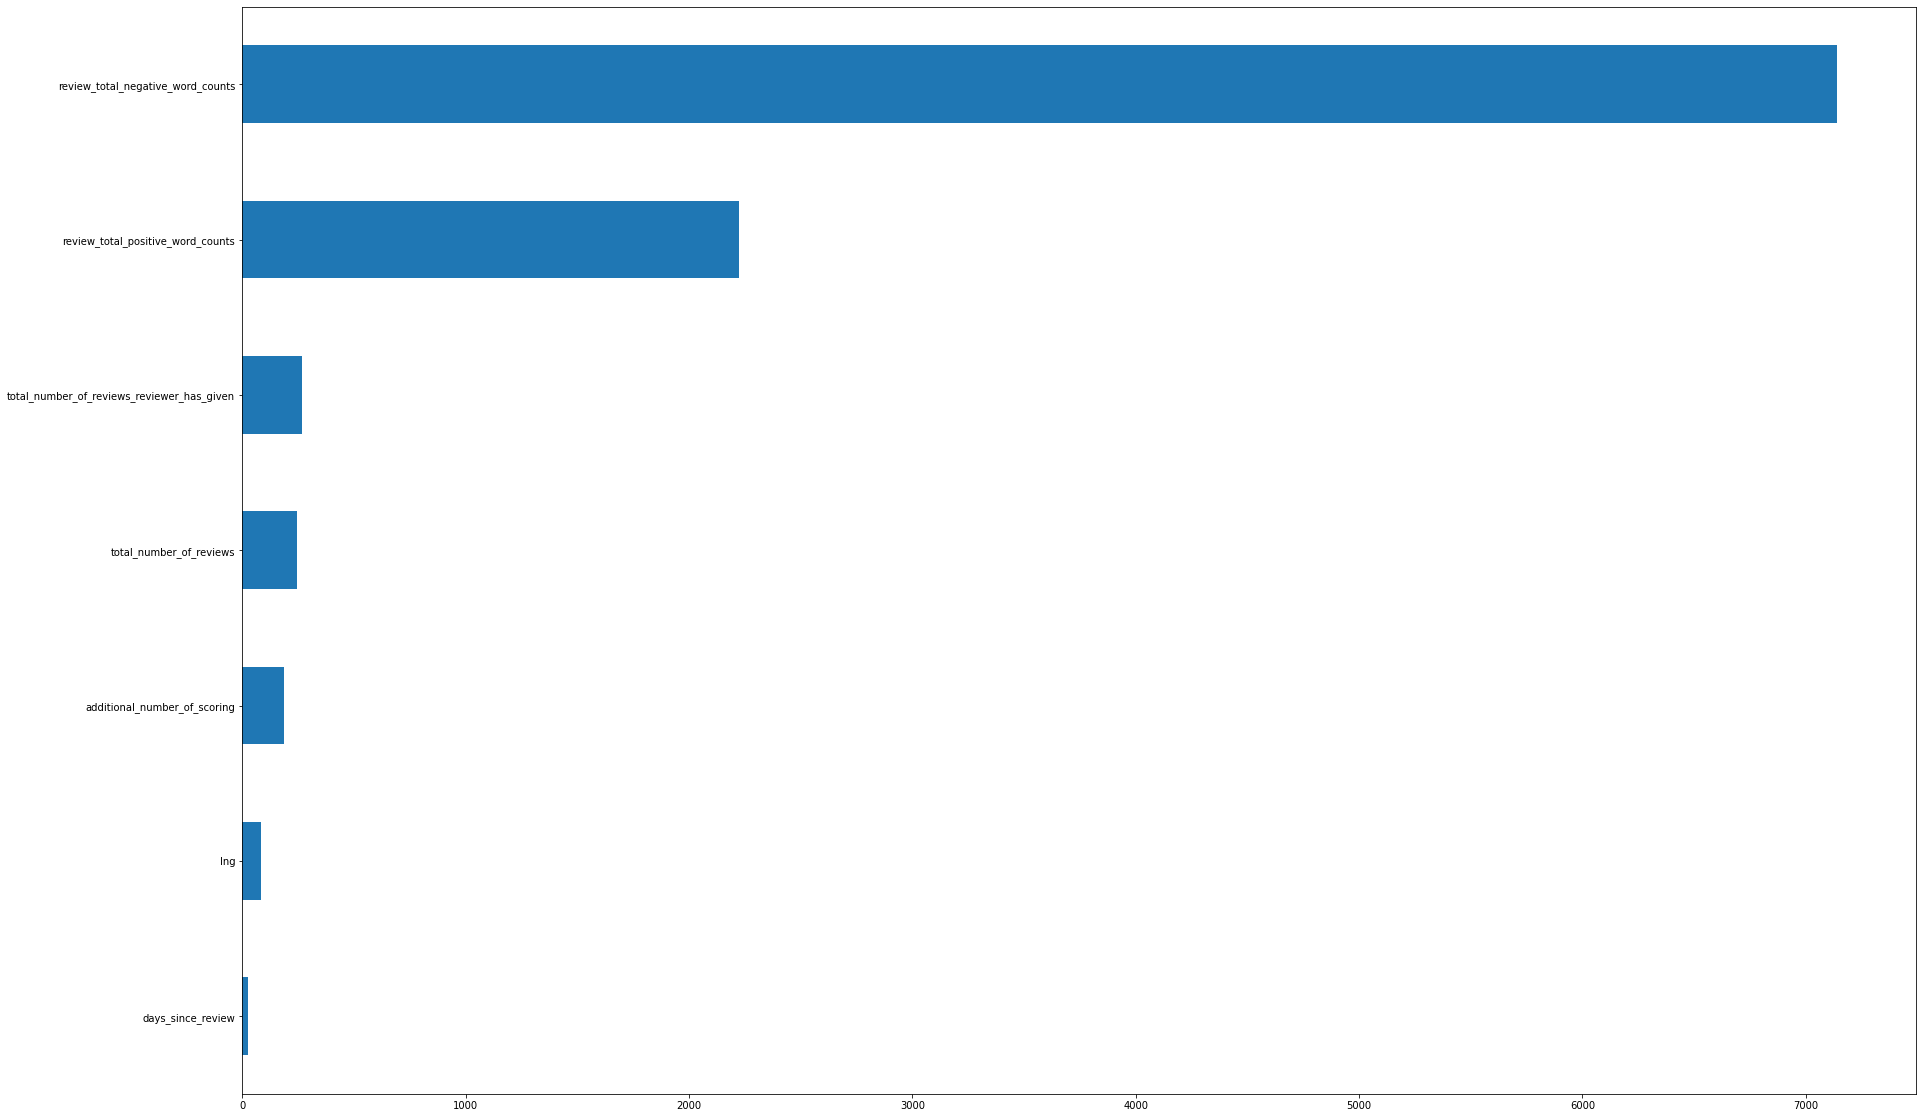

In [25]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(data[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

In [26]:
# отбираем столбцы для удаления
for_drop = ['city_1', 'city_2', 'city_3', 'city_4', 
            'city_5', 'city_6',
            'Leisure trip', 'year', 'lng', 'lat', ]

data = data.drop(for_drop, axis = 1)

# Преобразование признаков

In [27]:
data.describe()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,country_1,country_2,...,Superior Double or Twin Room,2 rooms,Stayed 6 nights,Standard Twin Room,Single Room,Twin Room,Stayed 7 nights,Executive Double Room,Classic Double or Twin Room,Superior Twin Room
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.00000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,8.397487,18.539450,2743.743944,17.776458,7.166001,354.441932,0.749999,6.297672,0.072143,0.110936,...,0.026312,0.024030,0.018955,0.018895,0.01875,0.016134,0.014346,0.012458,0.011841,0.011758
std,0.548048,29.690831,2317.464868,21.804185,11.040228,208.928124,0.433014,3.902295,0.258725,0.314053,...,0.160061,0.153141,0.136367,0.136155,0.13564,0.125992,0.118914,0.110918,0.108172,0.107795
min,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.100000,2.000000,1161.000000,5.000000,1.000000,175.000000,0.250000,0.625000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.400000,9.000000,2134.000000,11.000000,3.000000,353.000000,1.000000,7.900000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.800000,23.000000,3613.000000,22.000000,8.000000,527.000000,1.000000,9.600000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.800000,408.000000,16670.000000,395.000000,355.000000,730.000000,1.000000,10.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


### Распределение признаков

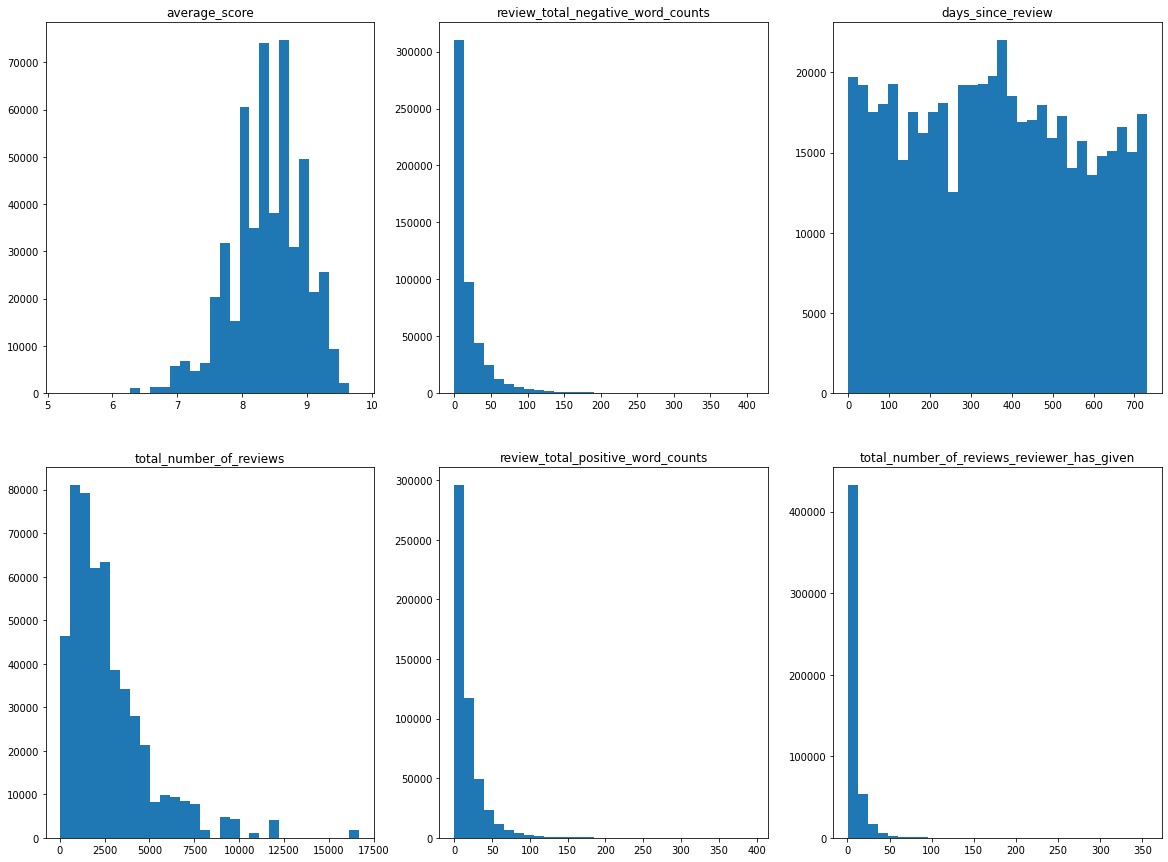

In [28]:
import matplotlib
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))

axes[0][0].hist(data['average_score'], bins=30)
axes[0][0].set_title('average_score')

axes[0][1].hist(data['review_total_negative_word_counts'], bins=30)
axes[0][1].set_title('review_total_negative_word_counts')

axes[0][2].hist(data['days_since_review'], bins=30)
axes[0][2].set_title('days_since_review')

axes[1][0].hist(data['total_number_of_reviews'], bins=30)
axes[1][0].set_title('total_number_of_reviews')

axes[1][1].hist(data['review_total_positive_word_counts'], bins=30)
axes[1][1].set_title('review_total_positive_word_counts')

axes[1][2].hist(data['total_number_of_reviews_reviewer_has_given'], bins=30)
axes[1][2].set_title('total_number_of_reviews_reviewer_has_given');


Нет нормально распределённых признаков. Проведём нормализацию.

### Нормализация

In [30]:
from sklearn import preprocessing

# Копируем названия столбцов, которые теряются при использовании fit_transform()
#col_names = list(data.columns)
col_names = [ 'additional_number_of_scoring',
'average_score',
'review_total_negative_word_counts',
'total_number_of_reviews',
'review_total_positive_word_counts', 
'total_number_of_reviews_reviewer_has_given',
'days_since_review']
# копируем индексы
ind = data.index

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
df_r = r_scaler.fit_transform(data[col_names])

df_r = pd.DataFrame(df_r, columns=col_names, index= ind)


In [31]:
# перезаписываем нормализированные признаки
data[col_names] = df_r[col_names]
data.head()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,country_1,country_2,...,Superior Double or Twin Room,2 rooms,Stayed 6 nights,Standard Twin Room,Single Room,Twin Room,Stayed 7 nights,Executive Double Room,Classic Double or Twin Room,Superior Twin Room
0,-0.428571,2.047619,5.928222,3.000000,-0.285714,-0.965909,0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.285714,0.047619,1.176183,-0.647059,0.571429,-0.338068,0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-0.142857,-0.285714,-0.727162,-0.352941,1.714286,0.747159,0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.000000,-0.428571,-0.241028,0.941176,0.857143,0.860795,0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.000000,-0.428571,1.041191,-0.235294,-0.142857,0.258523,0,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0


# Построение модели

In [32]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [33]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [34]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 57), (386803, 57), (386803, 56), (309442, 56), (77361, 56))

In [35]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [36]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [37]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [39]:
# функция Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [40]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.8964385930895407
MAE: 0.8964385930895407
MAPE: 12.864157982330967


<AxesSubplot:>

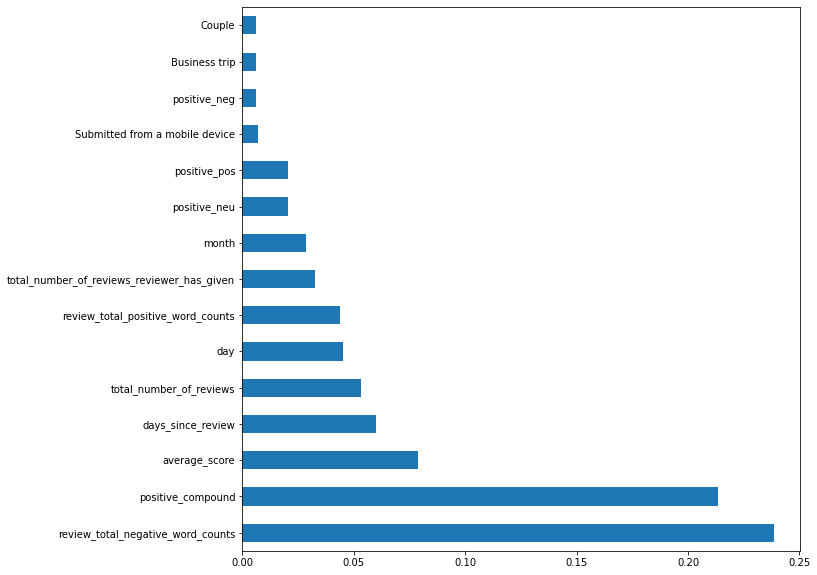

In [41]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [51]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,Superior Double or Twin Room,2 rooms,Stayed 6 nights,Standard Twin Room,Single Room,Twin Room,Stayed 7 nights,Executive Double Room,Classic Double or Twin Room,Superior Twin Room
102491,-0.264766,0.714286,0.333333,-0.251631,-0.411765,0.142857,-0.448864,41.386623,2.184072,0.0,...,0,0,0,0,0,0,0,0,0,0
65581,1.146640,-0.428571,-0.333333,5.928222,-0.235294,0.857143,0.181818,45.533137,9.171102,0.0,...,0,0,0,0,0,0,0,0,0,0
31309,1.997963,0.000000,-0.428571,1.624388,1.235294,0.285714,0.857955,51.501400,-0.116009,0.0,...,0,0,0,0,0,0,0,0,0,0
3210,-0.030550,0.571429,-0.428571,-0.183116,1.588235,2.000000,0.553977,51.510146,-0.131506,0.0,...,0,0,0,0,0,0,0,0,0,0
30132,-0.179226,-0.285714,-0.095238,-0.384584,-0.117647,-0.285714,-0.485795,51.480163,-0.009720,0.0,...,0,0,0,0,0,0,0,0,0,0
50977,0.739308,-0.142857,1.333333,0.126020,0.000000,-0.285714,0.514205,51.491959,-0.220096,0.0,...,0,0,0,0,0,0,0,0,0,0
14344,-0.470468,-1.142857,0.000000,-0.390701,-0.647059,3.857143,0.917614,48.855427,2.415256,0.0,...,0,0,0,0,0,0,0,0,0,0
42870,1.951120,0.428571,2.190476,1.329527,1.529412,-0.285714,0.798295,51.498673,-0.137687,0.0,...,0,0,0,0,0,0,0,0,0,0
92391,1.289206,0.857143,-0.428571,0.369494,0.588235,-0.142857,-1.000000,51.500732,-0.016550,0.0,...,0,0,0,0,0,0,0,0,0,0
37328,-0.173116,1.000000,0.857143,-0.483279,-0.647059,0.857143,0.474432,51.516048,-0.088018,0.0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

In [43]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


In [54]:
predict_submission

array([8.403, 7.105, 8.675, ..., 8.323, 9.621, 7.285])

In [44]:
list(sample_submission)

['reviewer_score', 'id']

In [45]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.788,488440
1,7.472,274649
2,8.710,374688
3,9.724,404352
4,9.718,451596
5,8.397,302161
6,7.839,317079
7,7.414,13963
8,8.530,159785
9,7.405,195089
